In [48]:
import os
import pandas as pd
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

In [2]:
print(torch.__version__)
print(torchaudio.__version__)

2.4.0+cpu
2.4.0+cpu


In [3]:
input_dir = "/kaggle/input/depression-audio/daic-woz-dataset"
output_dir = "/kaggle/working"

DATASET_DIR = f"{input_dir}/extracted_audio"
DATAINFO_DIR = f"{input_dir}/dataset_info"

In [5]:
def create_melspectogram(files, split_type):
    melspectograms = []
    for file in files:
        audio_path = os.path.join(DATASET_DIR, split_type, file)
        wfm, sr = torchaudio.load(audio_path)
        melspectogram = torchaudio.transforms.MelSpectrogram(
            n_fft=1024, n_mels=128, hop_length=512, sample_rate=sr, norm="slaney"
        )(wfm)
        melspectogram = melspectogram.to(torch.float16)
        melspectograms.append(melspectogram)
    return melspectograms

In [6]:
audio_path = os.path.join(DATASET_DIR, "train", "302_AUDIO.wav")
wfm, sr = torchaudio.load(audio_path)
sr

22050

In [7]:
wfm.shape

torch.Size([1, 4811311])

In [10]:
train_files = sorted(os.listdir(os.path.join(DATASET_DIR, "train")))

train_spectograms = create_melspectogram(train_files, "train")

In [11]:
print(len(train_spectograms), len(train_files))

274 274


In [13]:
torch.save(train_spectograms, f"{output_dir}/raw_train_spectograms.pkl")

## Splitting spectograms into segments

Each segement will be of specific length to avoid huge padding. Since largest spectogram is of shape 67856 whereas smallest is of 3459. Starting with 4096 as segment length. 4096 segment will correspond to approximate 2 minutes of audio.

In [22]:
train_spectograms = torch.load("/kaggle/input/depression-audio/raw_train_melspectograms.pkl")

/tmp/ipykernel_30/2674431718.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_spectograms = torch.load("/kaggle/input/depression-audio/raw_train_melspectograms.pkl"

In [7]:
all_shapes = [spect.shape[-1] for spect in train_spectograms]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


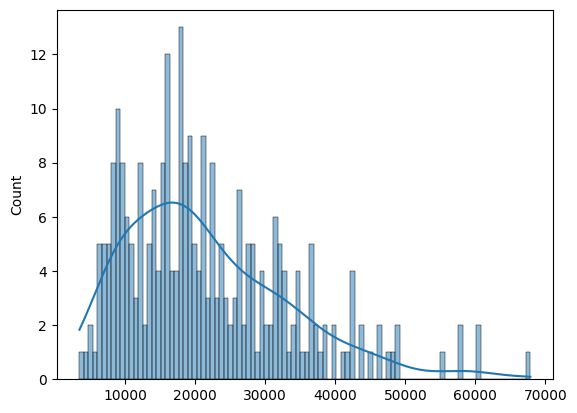

In [8]:
sns.histplot(all_shapes, bins=100, kde=True)
plt.show()

In [43]:
WINDOW_SIZE = 8192
OVERLAP_SAMPLES = 1024 # this much samples will be overlapped from the end of particular window
SKIP = WINDOW_SIZE - OVERLAP_SAMPLES
print(SKIP)

7168


In [44]:
def segment_spectograms(all_spectograms, WINDOW_SIZE, SKIP):
    all_segments = []
    for spectogram in all_spectograms:
        segments = []
        
        # Pad the spectrogram if its length isn't a multiple of WINDOW_SIZE
        if spectogram.shape[-1] % WINDOW_SIZE != 0:
            pad_len = WINDOW_SIZE - (spectogram.shape[-1] % WINDOW_SIZE)
            spectogram = torch.nn.functional.pad(spectogram, (0, pad_len))
            # print(spectogram.shape)
        
        # Segmenting the spectrogram
        for i in range(0, spectogram.shape[-1] - WINDOW_SIZE+1, SKIP):
            segment = spectogram[:, :, i:i+WINDOW_SIZE]
            segments.append(segment)
        
        # Stack segments into a single tensor
        spectogram = torch.stack(segments, dim=1)
        # print(spectogram.shape)
        
        all_segments.append(spectogram)
    return all_segments


In [45]:
all_segments =  segment_spectograms(train_spectograms, WINDOW_SIZE, SKIP)

In [46]:
len(all_segments), len(train_spectograms)

(274, 274)

In [50]:
torch.save(all_segments, f"{output_dir}/train_segmented_spectograms.pkl")

In [52]:
!zip -r file.zip /kaggle/working

updating: kaggle/working/ (stored 0%)
updating: kaggle/working/train_segmented_spectograms.pkl (deflated 46%)
updating: kaggle/working/.virtual_documents/ (stored 0%)


In [53]:
!ls

file.zip  train_segmented_spectograms.pkl


In [54]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

# Replicating Labels as per Segments

In [71]:
number_of_segments = [] # will hold count for each audio suggesting the number of segments of spectogram each audio had

for segment in all_segments:
    number_of_segments.append(segment.shape[1])
    
len(number_of_segments), number_of_segments[0]

(274, 2)

In [77]:
number_of_segments = np.array(number_of_segments)

np.save("number_of_segments.npy", number_of_segments)

need to replicate

# Stack all the segments

In [72]:
train_stacked_seg_spect = torch.cat(all_segments, dim=1)
train_stacked_seg_spect.shape

torch.Size([1, 866, 128, 8192])

In [73]:
train_stacked_seg_spect = torch.squeeze(train_stacked_seg_spect, dim=0)
train_stacked_seg_spect.shape

torch.Size([866, 128, 8192])

In [76]:
torch.save(train_stacked_seg_spect, f"{output_dir}/train_stacked_seg_spect.pkl")

# Playground